In [1]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.6MB/s 
     |████████████████████████████████| 552kB 22.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=05f6c3f41d85f9edf9eee858a084828bd95a66ce06caabb07aea104ea4db0d1d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=9a2089974c2117a4eb58c7fded6f88e172b8079868c15d8a47c2402000ed1ec2
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
# Utilities
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import re
import spacy
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'it', 'aaa', 'ใใ', 'pron','zone', 'yama', 'young', 'york', 'yesterday', 'yeah', 'woman', 'yu'])

# models
import gensim
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora


# visualisation
import pyLDAvis.gensim
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()


# warnings
import warnings
warnings.filterwarnings("ignore")

PATH = "/content/drive/My Drive/sen_ana/"

In [0]:
# all functions

# text clean
def clean(x):
  #remove punctuation
  x=re.sub("[,\.!?]", "", x)
  #lower case
  x=x.lower()
  return x

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization

# Build the bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=[ "NOUN", "ADJ", 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Compute coherence scores from varying number of Topics
def Coherence(max_topic=10):
    coherence = []
    for i in tqdm(range(1,max_topic+1)):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)      
        topics = lda_model.print_topics()
        print(f'\nNumber of topic: {i} \n')
        for topic in topics:
            print(topic)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence.append(coherence_lda)
        print(f'\n Coherence Score: {coherence_lda}')
    plt.plot(range(1,max_topic+1),coherence,label='Coherence')
    plt.xlabel('Coherence')
    plt.ylabel('Score')
    plt.xticks(range(1,max_topic+1))
    plt.show()

In [68]:
df = pd.read_csv(PATH+"candidate_hospitals_translated.csv")
df

,comment,score,hospital,en
0,เคยได้ไปลองใช้บริการคลีนิคนอกเวลาของรามาเมื่อต...,5,ramathibodi-hospital,"Ever were going to try to use the service, the..."
1,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปี...,4,ramathibodi-hospital,I've been to Lasik the this good now. coming t...
2,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญ...,5,ramathibodi-hospital,Treatment for years since the age of 14 will n...
3,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย ...,3,ramathibodi-hospital,"Building the floor 2. place tools, modern look..."
4,Its a public hospital so service is bad (nurse...,4,ramathibodi-hospital,Its a public hospital so service is bad (the n...
...,...,...,...,...
702,ค่ำวันที่ 26 ตุลาคม 2559 เหตุการณ์ในวันนั้นฉัน...,5,king-chulalongkorn-memorial-hospital,"Evening of October 26, 2559 event on that day,..."
703,ทำเพื่ออะไรรีวิวนี้แต่เราไปรักษารพจุฬาก็ได้รับ...,5,king-chulalongkorn-memorial-hospital,"Do what for this review, but we to maintain th..."
704,ทาง รพ. บริการคนไข้ดีมาก ใส่ใจผู้ป่วย เป็นกันเ...,5,king-chulalongkorn-memorial-hospital,"The hospital. Services, patient, very attentiv..."
705,หมอเก่ง,3,king-chulalongkorn-memorial-hospital,The doctor brilliantly


In [0]:
# positive and negative topics

df_pos = df.loc[(df.score==4) | (df.score==5)]
df_neg = df.loc[(df.score==1) | (df.score==2)]

# rama
df_pos_rama = df_pos.loc[df_pos.hospital.isin(["ramathibodi-hospital"])]
df_neg_rama = df_neg.loc[df_neg.hospital.isin(["ramathibodi-hospital"])]

# sriraj
df_pos_sriraj = df_pos.loc[df_pos.hospital.isin(["siriraj-hospital"])]
df_neg_sriraj = df_neg.loc[df_neg.hospital.isin(["siriraj-hospital"])]

# chula
df_pos_chula = df_pos.loc[df_pos.hospital.isin(["king-chulalongkorn-memorial-hospital"])]
df_neg_chula = df_neg.loc[df_neg.hospital.isin(["king-chulalongkorn-memorial-hospital"])]

# Ramathibodhi Positive

In [70]:
rama_pos = df_pos_rama["en"].map(lambda x: clean(x))
rama_pos

0      ever were going to try to use the service the ...
1      i've been to lasik the this good now coming to...
2      treatment for years since the age of 14 will n...
4      its a public hospital so service is bad (the n...
5      my friend is a disease about pulmonary leak do...
                             ...                        
216      doctor nurse care good car parking clean people
217    service good clean doctor ask at the hotel dul...
218                                    very good service
219    patients quite a lot to get the service quite ...
221    doctor good detailed instructions clear good s...
Name: en, Length: 162, dtype: object

In [71]:
data = rama_pos.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['ever', 'were', 'going', 'to', 'try', 'to', 'use', 'the', 'service', 'the', 'clinic', 'part', 'of', 'the', 'rama', 'at', 'the', 'beginning', 'of', 'last', 'treatment', 'of', 'laser', 'on', 'in', 'the', 'page', 'with', 'the', 'doctor', 'very', 'kind', 'and', 'friendly', 'take', 'care', 'of', 'thoroughly', 'wait', 'queues', 'shortly', 'but', 'to', 'call', 'and', 'reserve', 'in', 'advance', 'love', 'to', 'study', 'your', 'doctor', 'can', 'hurt', 'less', 'than', 'minutes', 'the', 'treatment', 'results', 'out', 'notch', 'leaves', 'on', 'the', 'page', 'missing', 'value', 'love', 'the', 'treatment', 'not', 'expensive']]


In [72]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized)

[['ever', 'go', 'try', 'service', 'clinic', 'part', 'begin', 'last', 'treatment', 'laser', 'page', 'doctor', 'kind', 'friendly', 'take', 'care', 'thoroughly', 'wait', 'queue', 'shortly', 'call', 'love', 'study', 'doctor', 'hurt', 'less', 'minute', 'treatment', 'result', 'notch', 'leave', 'page', 'miss', 'value', 'love', 'treatment', 'expensive'], ['come', 'year', 'side', 'price', 'good', 'middle', 'surgery', 'may', 'seem', 'scary', 'time', 'actually', 'feel', 'hurt', 'drop', 'anesthetic'], ['treatment', 'year', 'age', 'finish', 'degree', 'sleep', 'hospital', 'recover', 'well', 'live', 'life', 'normal', 'especially', 'clinical', 'premium', 'wait', 'long', 'convenient', 'fast', 'step', 'pay', 'pay', 'drug', 'cost', 'expensive', 'compare', 'private', 'sector', 'many', 'service', 'good', 'doctor', 'care', 'good', 'want'], ['public', 'service', 'bad', 'nurse', 'completely', 'unfriendly', 'doctor', 'horrifying', 'bed', 'side', 'manner', 'keep', 'alive', 'quality', 'life', 'decent', 'drug', '

In [73]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1)]]



Number of topic: 1 

(0, '0.031*"doctor" + 0.026*"good" + 0.017*"patient" + 0.013*"nurse" + 0.013*"hospital" + 0.011*"service" + 0.011*"care" + 0.011*"thank" + 0.008*"come" + 0.008*"time"')

 Coherence Score: 0.3380885100460623

Number of topic: 2 

(0, '0.021*"doctor" + 0.014*"thank" + 0.014*"patient" + 0.013*"nurse" + 0.011*"come" + 0.010*"good" + 0.009*"know" + 0.008*"bad" + 0.008*"hospital" + 0.007*"say"')
(1, '0.041*"good" + 0.041*"doctor" + 0.021*"service" + 0.020*"patient" + 0.017*"hospital" + 0.015*"care" + 0.012*"nurse" + 0.011*"treatment" + 0.010*"wait" + 0.010*"time"')

 Coherence Score: 0.3189287877119392

Number of topic: 3 

(0, '0.028*"doctor" + 0.018*"patient" + 0.017*"nurse" + 0.016*"thank" + 0.014*"good" + 0.012*"come" + 0.011*"know" + 0.010*"time" + 0.009*"hospital" + 0.009*"say"')
(1, '0.044*"good" + 0.038*"doctor" + 0.027*"service" + 0.019*"patient" + 0.018*"care" + 0.015*"hospital" + 0.014*"wait" + 0.013*"long" + 0.012*"nurse" + 0.010*"treatment"')
(2, '0.024*"do

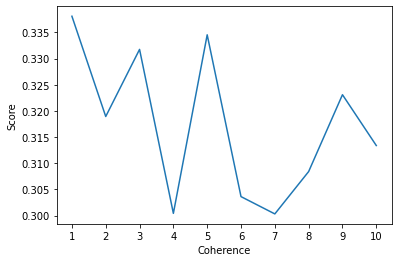

In [74]:
Coherence()

In [75]:
# 5 Topics gave best result
lda_rama_pos = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

rama_pos = pyLDAvis.gensim.prepare(lda_rama_pos, corpus, id2word)
rama_pos

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.077521  0.036201       1        1  29.123106
1      0.119007 -0.024146       2        1  24.710548
0     -0.082037  0.032523       3        1  24.076523
3     -0.058145 -0.124225       4        1  13.588999
2     -0.056346  0.079647       5        1   8.500820, topic_info=          Term       Freq      Total Category  logprob  loglift
23     service  32.000000  32.000000  Default  30.0000  30.0000
37        good  79.000000  79.000000  Default  29.0000  29.0000
2         care  32.000000  32.000000  Default  28.0000  28.0000
71        well  17.000000  17.000000  Default  27.0000  27.0000
31        wait  19.000000  19.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
180    patient   2.035592  53.435432   Topic5  -4.8510  -0.8027
2         care   1.638456  32.939034   Topic5  -5.0681  -0.5359
4       doctor   1.752643  96.757866   Topic5  -5.0007  -1.5461
28   treatment   1.392774  21.000778   Topic5  -5.2305  -0.2483
291      speak   1.371145   6.764122   Topic5  -5.2462   0.8690

[338 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
439       2  0.784507    accord
594       3  0.675965       act
32        1  0.308329  actually
32        4  0.616658  actually
273       1  0.218263       add
...     ...       ...       ...
46        1  0.245871      year
46        2  0.307338      year
46        3  0.245871      year
46        4  0.122935      year
46        5  0.122935      year

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])

# Ramathibodhi Negative


Number of topic: 1 

(0, '0.017*"say" + 0.016*"nurse" + 0.016*"patient" + 0.015*"doctor" + 0.014*"time" + 0.014*"bad" + 0.012*"service" + 0.012*"go" + 0.011*"come" + 0.011*"wait"')

 Coherence Score: 0.4678249502585755

Number of topic: 2 

(0, '0.021*"patient" + 0.015*"doctor" + 0.014*"go" + 0.014*"wait" + 0.013*"come" + 0.013*"service" + 0.012*"hospital" + 0.012*"say" + 0.011*"make" + 0.011*"nurse"')
(1, '0.022*"say" + 0.020*"nurse" + 0.019*"bad" + 0.017*"time" + 0.014*"doctor" + 0.013*"people" + 0.011*"room" + 0.011*"speak" + 0.010*"work" + 0.010*"service"')

 Coherence Score: 0.4962776977958582

Number of topic: 3 

(0, '0.018*"come" + 0.017*"service" + 0.016*"wait" + 0.015*"doctor" + 0.015*"patient" + 0.013*"say" + 0.013*"afternoon" + 0.012*"go" + 0.012*"time" + 0.011*"file"')
(1, '0.028*"time" + 0.017*"work" + 0.013*"go" + 0.012*"nurse" + 0.012*"room" + 0.011*"system" + 0.011*"doctor" + 0.011*"speak" + 0.011*"say" + 0.010*"wait"')
(2, '0.026*"say" + 0.025*"bad" + 0.024*"nurse" +

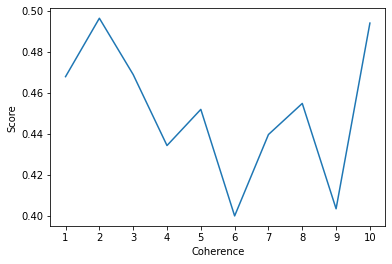

In [76]:
rama_neg = df_neg_rama["en"].map(lambda x: clean(x))
data = rama_neg.values.tolist()
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Coherence()

In [77]:
# 2 Topics gave best result
lda_rama_neg = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=2, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

rama_neg = pyLDAvis.gensim.prepare(lda_rama_neg, corpus, id2word)
rama_neg

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.059009  0.0       1        1  52.218884
0     -0.059009  0.0       2        1  47.781113, topic_info=           Term      Freq      Total Category  logprob  loglift
63    afternoon  5.000000   5.000000  Default  30.0000  30.0000
73         file  5.000000   5.000000  Default  29.0000  29.0000
21         room  8.000000   8.000000  Default  28.0000  28.0000
79   medication  4.000000   4.000000  Default  27.0000  27.0000
172        call  6.000000   6.000000  Default  26.0000  26.0000
..          ...       ...        ...      ...      ...      ...
118       staff  3.180661   4.952996   Topic2  -5.2598   0.2956
65          bad  5.282917  17.822203   Topic2  -4.7524  -0.4774
58     terrible  3.906771   9.242178   Topic2  -5.0541  -0.1225
121   treatment  3.241603   8.539217   Topic2  -5.2408  -0.2301
197         ask  3.185114   9.257964   Topic2  -5.2584  -0.3285

[144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
63        2  0.888888  afternoon
64        2  0.945986        age
331       2  0.710135       also
300       1  0.932483     anyhow
197       1  0.648091        ask
...     ...       ...        ...
217       2  0.627667       want
194       1  0.932491       word
195       1  0.754792       work
195       2  0.215655       work
325       1  1.048104      wrong

[136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# Sriraj Positive


Number of topic: 1 

(0, '0.037*"doctor" + 0.018*"good" + 0.017*"patient" + 0.015*"nurse" + 0.015*"care" + 0.014*"hospital" + 0.013*"service" + 0.012*"take" + 0.011*"time" + 0.009*"find"')

 Coherence Score: 0.39065783029332707

Number of topic: 2 

(0, '0.041*"doctor" + 0.021*"patient" + 0.017*"good" + 0.015*"hospital" + 0.015*"time" + 0.014*"nurse" + 0.011*"go" + 0.010*"treatment" + 0.009*"service" + 0.008*"wait"')
(1, '0.037*"care" + 0.030*"doctor" + 0.025*"take" + 0.020*"good" + 0.018*"service" + 0.017*"nurse" + 0.016*"find" + 0.013*"thank" + 0.012*"hospital" + 0.011*"people"')

 Coherence Score: 0.3865747091507795

Number of topic: 3 

(0, '0.043*"doctor" + 0.035*"patient" + 0.022*"good" + 0.019*"nurse" + 0.017*"hospital" + 0.016*"time" + 0.014*"wait" + 0.013*"go" + 0.009*"siriraj" + 0.009*"staff"')
(1, '0.043*"service" + 0.034*"good" + 0.025*"people" + 0.016*"lot" + 0.015*"overall" + 0.014*"speak" + 0.014*"time" + 0.013*"use" + 0.013*"doctor" + 0.013*"patient"')
(2, '0.041*"doct

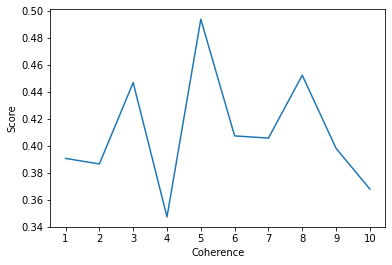

In [78]:
sriraj_pos = df_pos_sriraj["en"].map(lambda x: clean(x))
data = sriraj_pos.values.tolist()
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Coherence()

In [80]:
# 5 Topics gave best result
lda_sriraj_pos = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

sriraj_pos = pyLDAvis.gensim.prepare(lda_sriraj_pos, corpus, id2word)
sriraj_pos

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.167230  0.055726       1        1  41.794342
0     -0.048497 -0.073050       2        1  33.966400
4      0.018767  0.008237       3        1  15.635519
1      0.076325 -0.102129       4        1   5.740102
3      0.120636  0.111216       5        1   2.863644, topic_info=         Term       Freq      Total Category  logprob  loglift
10       good  58.000000  58.000000  Default  30.0000  30.0000
123   service  26.000000  26.000000  Default  29.0000  29.0000
20    patient  66.000000  66.000000  Default  28.0000  28.0000
66       care  52.000000  52.000000  Default  27.0000  27.0000
77     people  13.000000  13.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
41     enough   0.195136   9.515276   Topic5  -6.1869  -0.3339
707      busy   0.191879   2.092419   Topic5  -6.2037   1.1639
101  separate   0.191428   2.810800   Topic5  -6.2061   0.8664
651      pass   0.191421   1.672144   Topic5  -6.2061   1.3857
182      must   0.191392   9.245862   Topic5  -6.2063  -0.3245

[270 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
568       1  0.423938   advice
568       2  0.545063   advice
727       2  0.867447      age
212       3  0.494267      air
908       2  0.920982  already
...     ...       ...      ...
32        2  0.867249     wide
251       2  0.845486     work
128       1  0.956455     year
920       5  0.794505    young
739       2  0.709741      คลำ

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

# Sriraj Negative


Number of topic: 1 

(0, '0.047*"doctor" + 0.031*"patient" + 0.023*"neck" + 0.019*"make" + 0.019*"treatment" + 0.019*"good" + 0.016*"surgery" + 0.016*"tell" + 0.016*"year" + 0.016*"need"')

 Coherence Score: 0.37721315338807976

Number of topic: 2 

(0, '0.061*"neck" + 0.039*"good" + 0.028*"doctor" + 0.028*"bad" + 0.017*"need" + 0.017*"year" + 0.017*"surgery" + 0.017*"make" + 0.017*"surgical" + 0.017*"big"')
(1, '0.057*"doctor" + 0.045*"patient" + 0.027*"treatment" + 0.021*"time" + 0.021*"tell" + 0.021*"say" + 0.021*"make" + 0.015*"lot" + 0.015*"last" + 0.015*"disease"')

 Coherence Score: 0.7026973341941241

Number of topic: 3 

(0, '0.073*"neck" + 0.046*"good" + 0.032*"doctor" + 0.032*"bad" + 0.018*"make" + 0.018*"need" + 0.018*"year" + 0.018*"tablet" + 0.018*"big" + 0.018*"fasten"')
(1, '0.054*"doctor" + 0.029*"time" + 0.029*"need" + 0.029*"hospital" + 0.029*"make" + 0.029*"surgery" + 0.029*"year" + 0.017*"many" + 0.017*"check" + 0.017*"go"')
(2, '0.061*"patient" + 0.051*"doctor" +

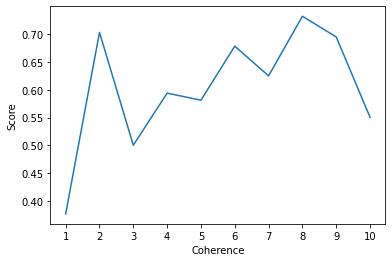

In [81]:
sriraj_neg = df_neg_sriraj["en"].map(lambda x: clean(x))
data = sriraj_neg.values.tolist()
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Coherence()

In [82]:
# 8 Topics gave best result
lda_sriraj_neg = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

sriraj_neg = pyLDAvis.gensim.prepare(lda_sriraj_neg, corpus, id2word)
sriraj_neg

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.187444  0.059523       1        1  41.087715
4      0.044475 -0.138496       2        1  24.710379
0      0.148873  0.120600       3        1  24.660149
5      0.009687 -0.058868       4        1   7.700205
7     -0.002991  0.004780       5        1   0.460387
3     -0.003776  0.003999       6        1   0.460387
2     -0.005043  0.004461       7        1   0.460387
1     -0.003781  0.004001       8        1   0.460387, topic_info=         Term      Freq     Total Category  logprob  loglift
48    patient  6.000000  6.000000  Default  30.0000  30.0000
12       neck  4.000000  4.000000  Default  29.0000  29.0000
84        say  2.000000  2.000000  Default  28.0000  28.0000
9        good  3.000000  3.000000  Default  27.0000  27.0000
44  treatment  3.000000  3.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
74    improve  0.006709  1.185402   Topic8  -4.6539   0.2064
77       lose  0.006709  1.185835   Topic8  -4.6539   0.2060
71     enough  0.006709  1.185415   Topic8  -4.6539   0.2064
38        lot  0.006709  1.910223   Topic8  -4.6539  -0.2707
69    despair  0.006709  1.185617   Topic8  -4.6539   0.2062

[405 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
51        2  0.913069    according
0         3  0.902417          ago
61        1  0.843530      already
52        2  0.913069  appointment
1         3  1.083232          bad
...     ...       ...          ...
104       4  1.191522       update
94        1  0.843482        voice
45        2  0.913069         walk
29        2  0.781830         year
29        3  0.390915         year

[117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 1, 6, 8, 4, 3, 2])

# Chulalongkorn Positive


Number of topic: 1 

(0, '0.038*"doctor" + 0.030*"good" + 0.018*"service" + 0.017*"patient" + 0.015*"hospital" + 0.013*"care" + 0.011*"nurse" + 0.010*"come" + 0.009*"take" + 0.009*"wait"')

 Coherence Score: 0.43606599740231705

Number of topic: 2 

(0, '0.031*"doctor" + 0.017*"husband" + 0.016*"come" + 0.016*"say" + 0.014*"thank" + 0.012*"nurse" + 0.012*"blood" + 0.012*"take" + 0.011*"good" + 0.011*"service"')
(1, '0.044*"good" + 0.043*"doctor" + 0.024*"service" + 0.023*"patient" + 0.021*"hospital" + 0.017*"care" + 0.011*"nurse" + 0.010*"lot" + 0.010*"time" + 0.009*"wait"')

 Coherence Score: 0.4888654875277655

Number of topic: 3 

(0, '0.023*"doctor" + 0.016*"care" + 0.016*"mother" + 0.015*"good" + 0.014*"birth" + 0.013*"service" + 0.011*"many" + 0.011*"staff" + 0.010*"system" + 0.010*"great"')
(1, '0.040*"doctor" + 0.037*"patient" + 0.033*"service" + 0.023*"good" + 0.019*"care" + 0.016*"hospital" + 0.013*"nurse" + 0.010*"wait" + 0.010*"long" + 0.010*"time"')
(2, '0.041*"doctor" + 

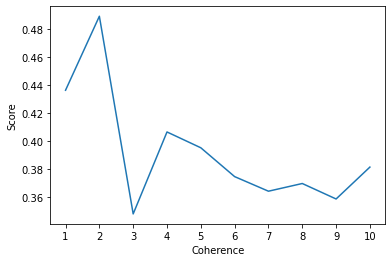

In [87]:
chula_pos = df_pos_chula["en"].map(lambda x: clean(x))
data = chula_pos.values.tolist()
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Coherence()

In [88]:
# 2 Topics gave best result
lda_chula_pos = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=2, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

chula_pos = pyLDAvis.gensim.prepare(lda_chula_pos, corpus, id2word)
chula_pos

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.095781  0.0       1        1  70.951256
0     -0.095781  0.0       2        1  29.048746, topic_info=          Term       Freq       Total Category  logprob  loglift
215    husband  18.000000   18.000000  Default  30.0000  30.0000
114      thank  15.000000   15.000000  Default  29.0000  29.0000
26         say  24.000000   24.000000  Default  28.0000  28.0000
68       blood  13.000000   13.000000  Default  27.0000  27.0000
92        come  32.000000   32.000000  Default  26.0000  26.0000
..         ...        ...         ...      ...      ...      ...
141    patient  11.118127   70.095177   Topic2  -4.5563  -0.6051
66   treatment   8.603429   29.972336   Topic2  -4.8128  -0.0119
44        good  12.161543  125.917999   Topic2  -4.4666  -1.1012
107       care   8.027156   53.054497   Topic2  -4.8821  -0.6523
75    hospital   7.893442   61.726742   Topic2  -4.8989  -0.8205

[139 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
916       2  0.893511      afraid
299       1  0.953707        also
426       1  0.934054  appreciate
126       1  0.468939         ask
126       2  0.573148         ask
...     ...       ...         ...
104       1  0.727536        wait
104       2  0.272826        wait
959       2  0.893510        wash
228       1  0.748657        well
228       2  0.233955        well

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# Chulalongkorn Negative


Number of topic: 1 

(0, '0.013*"wait" + 0.013*"come" + 0.012*"go" + 0.012*"time" + 0.011*"hospital" + 0.011*"doctor" + 0.011*"nurse" + 0.011*"patient" + 0.010*"say" + 0.010*"people"')

 Coherence Score: 0.4530914168856581

Number of topic: 2 

(0, '0.017*"wait" + 0.015*"file" + 0.013*"come" + 0.013*"send" + 0.013*"hospital" + 0.012*"time" + 0.012*"doctor" + 0.011*"patient" + 0.011*"say" + 0.010*"check"')
(1, '0.015*"go" + 0.014*"service" + 0.013*"come" + 0.012*"work" + 0.012*"people" + 0.012*"time" + 0.011*"nurse" + 0.011*"doctor" + 0.011*"room" + 0.011*"hospital"')

 Coherence Score: 0.3942849786972075

Number of topic: 3 

(0, '0.023*"wait" + 0.019*"come" + 0.018*"time" + 0.017*"file" + 0.014*"nurse" + 0.014*"bad" + 0.014*"doctor" + 0.013*"send" + 0.012*"check" + 0.012*"say"')
(1, '0.018*"go" + 0.015*"work" + 0.014*"come" + 0.013*"say" + 0.013*"service" + 0.013*"people" + 0.011*"room" + 0.011*"doctor" + 0.011*"time" + 0.011*"wait"')
(2, '0.017*"hospital" + 0.015*"patient" + 0.009*"

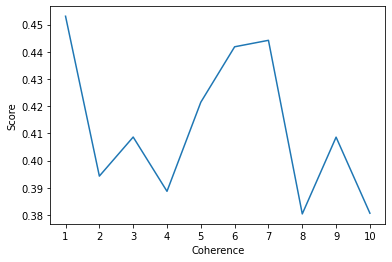

In [89]:
chula_neg = df_neg_chula["en"].map(lambda x: clean(x))
data = chula_neg.values.tolist()
data_words = list(sent_to_words(data))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Coherence()

In [90]:
# 1 Topic gave best result
lda_chula_neg = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=1, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

chula_neg = lda_chula_neg.show_topics(formatted=False)
chula_neg

[(0,
  [('wait', 0.012906313),
   ('come', 0.01290631),
   ('go', 0.011950287),
   ('time', 0.011950287),
   ('hospital', 0.011472275),
   ('doctor', 0.011472275),
   ('nurse', 0.010516253),
   ('patient', 0.010516252),
   ('say', 0.010038243),
   ('people', 0.010038241)])]